In [27]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

In [28]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

print(train_data)
print(test_data)
print(train_data.data.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])


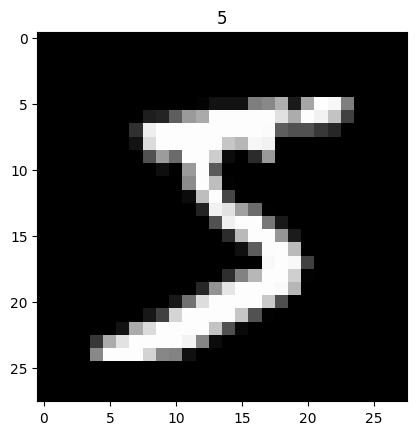

In [30]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

In [31]:
loaders = {
    'train': torch.utils.data.DataLoader(train_data,
                                         batch_size=100,
                                         shuffle=True,
                                         num_workers=1),

    'test': torch.utils.data.DataLoader(test_data,
                                        batch_size=100,
                                        shuffle=True,
                                        num_workers=1),
}

loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x283e0454400>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x283e0457430>}

In [32]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )

        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        

        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)    

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [33]:
cnn = CNN()
print(cnn)
loss_func = nn.CrossEntropyLoss()
print(loss_func)
optimizer = optim.Adam(cnn.parameters(), lr=0.01)
print(optimizer)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [34]:
num_epochs = 10

def train(num_epochs, cnn, loaders):
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()                # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))               
                pass
        pass
    pass
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.1699
Epoch [1/10], Step [200/600], Loss: 0.2566
Epoch [1/10], Step [300/600], Loss: 0.1454
Epoch [1/10], Step [400/600], Loss: 0.0987
Epoch [1/10], Step [500/600], Loss: 0.1084
Epoch [1/10], Step [600/600], Loss: 0.1623
Epoch [2/10], Step [100/600], Loss: 0.1923
Epoch [2/10], Step [200/600], Loss: 0.0663
Epoch [2/10], Step [300/600], Loss: 0.0674
Epoch [2/10], Step [400/600], Loss: 0.0439
Epoch [2/10], Step [500/600], Loss: 0.0870
Epoch [2/10], Step [600/600], Loss: 0.0278
Epoch [3/10], Step [100/600], Loss: 0.0301
Epoch [3/10], Step [200/600], Loss: 0.0100
Epoch [3/10], Step [300/600], Loss: 0.0701
Epoch [3/10], Step [400/600], Loss: 0.0771
Epoch [3/10], Step [500/600], Loss: 0.0484
Epoch [3/10], Step [600/600], Loss: 0.0415
Epoch [4/10], Step [100/600], Loss: 0.0472
Epoch [4/10], Step [200/600], Loss: 0.1659
Epoch [4/10], Step [300/600], Loss: 0.0785
Epoch [4/10], Step [400/600], Loss: 0.0377
Epoch [4/10], Step [500/600], Loss: 0.0835
Epoch [4/10

In [35]:
def test():
    # Test the model
    cnn.eval()    
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    pass

test()

Test Accuracy of the model on the 10000 test images: 0.99
